# Proyecto B — Clasificación Multiclase de Objetos Estelares

**Estudiante:** Joan Sebasttian Montes Jerez  
**Curso:** Inteligencia Artificial - Universidad Agustiniana  
**Fecha:** Noviembre 2025

---

## Introducción

Este proyecto aborda un problema de **clasificación multiclase con alta dimensionalidad** utilizando el dataset "Stellar Classification Dataset - SDSS17" del Sloan Digital Sky Survey.

**Objetivo:** Construir un clasificador robusto que identifique el tipo de objeto astronómico (GALAXY, STAR, QSO) a partir de sus características espectrales y fotométricas.

**Dataset:** 100,000 observaciones astronómicas con 17 características numéricas.

**Tareas principales:**
1. Análisis exploratorio de datos (EDA)
2. Preprocesamiento y limpieza
3. Reducción de dimensionalidad (PCA)
4. Entrenamiento y comparación de múltiples modelos
5. Calibración de probabilidades
6. Interpretabilidad y análisis de errores
7. Evaluación de robustez
8. Conclusiones y recomendaciones

---

## 0. Configuración del Entorno

Se configuran las librerías necesarias y se verifican las versiones para garantizar la reproducibilidad del análisis.


In [1]:
# Importaciones básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importaciones para preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Importaciones para modelado
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Importaciones para evaluación
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Importaciones para reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


---

## 1. Carga de Datos y Exploración Inicial (EDA)

En esta sección se carga el dataset de clasificación estelar del SDSS17 y se realiza un análisis exploratorio para entender:

- Las dimensiones y estructura del dataset
- La distribución de la variable objetivo (clases)
- Las características de las variables explicativas
- Presencia de valores faltantes o anomalías
- Relaciones entre variables (correlaciones)

El dataset proviene del Sloan Digital Sky Survey (SDSS17) y contiene observaciones de 100,000 objetos astronómicos clasificados en tres categorías:
- **GALAXY**: Galaxias
- **STAR**: Estrellas
- **QSO**: Quásares (objetos cuasi-estelares)

In [3]:
# Cargar el dataset
ruta_datos = 'Data/archive/star_classification.csv'
df = pd.read_csv(ruta_datos)

# Mostrar las primeras filas
print("=" * 60)
print("PRIMERAS FILAS DEL DATASET")
print("=" * 60)
print(df.head())


PRIMERAS FILAS DEL DATASET
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354    

In [4]:
# Información general del dataset
print("\n" + "=" * 60)
print("INFORMACIÓN GENERAL")
print("=" * 60)
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nTipos de datos:\n{df.dtypes}")



INFORMACIÓN GENERAL
Dimensiones: 100000 filas x 18 columnas

Tipos de datos:
obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object


### 1.2 Descripción de las Variables

El dataset contiene las siguientes variables:

**Variables identificadoras:**
- `obj_ID`: Identificador único del objeto
- `run_ID`, `rerun_ID`, `cam_col`, `field_ID`: Identificadores de observación

**Variables astronómicas:**
- `alpha`: Ascensión recta (ángulo)
- `delta`: Declinación (ángulo)
- `u, g, r, i, z`: Magnitudes en filtros ultravioleta, verde, rojo, infrarrojo cercano y lejano
- `redshift`: Corrimiento al rojo (importante para quásares)
- `plate`, `MJD`, `fiber_ID`: Información de placa espectroscópica

**Variable objetivo:**
- `class`: Tipo de objeto (GALAXY, STAR, QSO)


In [5]:
# Análisis de valores faltantes
print("=" * 60)
print("VALORES FALTANTES POR COLUMNA")
print("=" * 60)
valores_faltantes = df.isnull().sum()
porcentaje_faltantes = (valores_faltantes / len(df)) * 100

faltantes_df = pd.DataFrame({
    'Valores Faltantes': valores_faltantes,
    'Porcentaje': porcentaje_faltantes
})
print(faltantes_df[faltantes_df['Valores Faltantes'] > 0])

if valores_faltantes.sum() == 0:
    print("\nNo se detectaron valores faltantes en el dataset.")


VALORES FALTANTES POR COLUMNA
Empty DataFrame
Columns: [Valores Faltantes, Porcentaje]
Index: []

No se detectaron valores faltantes en el dataset.


### 1.3 Distribución de la Variable Objetivo

Analizar la distribución de las clases es fundamental para:
- Detectar posibles desbalances que requieran técnicas especiales
- Entender la proporción de cada tipo de objeto astronómico
- Planificar estrategias de validación (estratificación)

In [6]:
# Distribución de la variable objetivo
print("=" * 60)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 60)

distribucion_clases = df['class'].value_counts()
print(distribucion_clases)
print(f"\nPorcentajes:")
print(df['class'].value_counts(normalize=True) * 100)


DISTRIBUCIÓN DE CLASES
class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

Porcentajes:
class
GALAXY    59.445
STAR      21.594
QSO       18.961
Name: proportion, dtype: float64


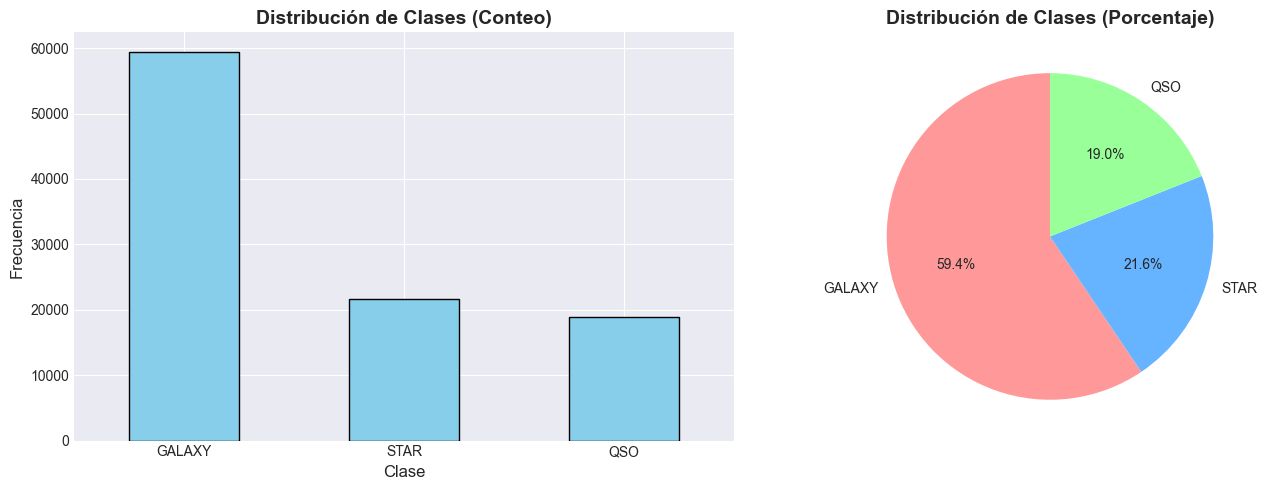

In [7]:
# Visualización de distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
distribucion_clases.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Clases (Conteo)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)

# Gráfico de pastel
axes[1].pie(distribucion_clases, labels=distribucion_clases.index, autopct='%1.1f%%',
            startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
axes[1].set_title('Distribución de Clases (Porcentaje)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 1.4 Estadísticas Descriptivas

Se calculan estadísticas descriptivas de las variables numéricas.


In [8]:
# Seleccionar solo columnas numéricas (excluir identificadores y clase)
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir identificadores
columnas_caracteristicas = [col for col in columnas_numericas 
                            if col not in ['obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 'plate', 'MJD', 'fiber_ID']]

print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 60)
print(df[columnas_caracteristicas].describe())


ESTADÍSTICAS DESCRIPTIVAS
               alpha          delta              u              g  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      177.629117      24.135305      21.980468      20.531387   
std        96.502241      19.644665      31.769291      31.750292   
min         0.005528     -18.785328   -9999.000000   -9999.000000   
25%       127.518222       5.146771      20.352353      18.965230   
50%       180.900700      23.645922      22.179135      21.099835   
75%       233.895005      39.901550      23.687440      22.123767   
max       359.999810      83.000519      32.781390      31.602240   

                   r              i              z        cam_col  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       19.645762      19.084854      18.668810       3.511610   
std         1.854760       1.757895      31.728152       1.586912   
min         9.822070       9.469903   -9999.000000       1.000000   
25%    

### 1.5 Matriz de Correlación

Se analiza la correlación entre variables para identificar posibles multicolinealidades.


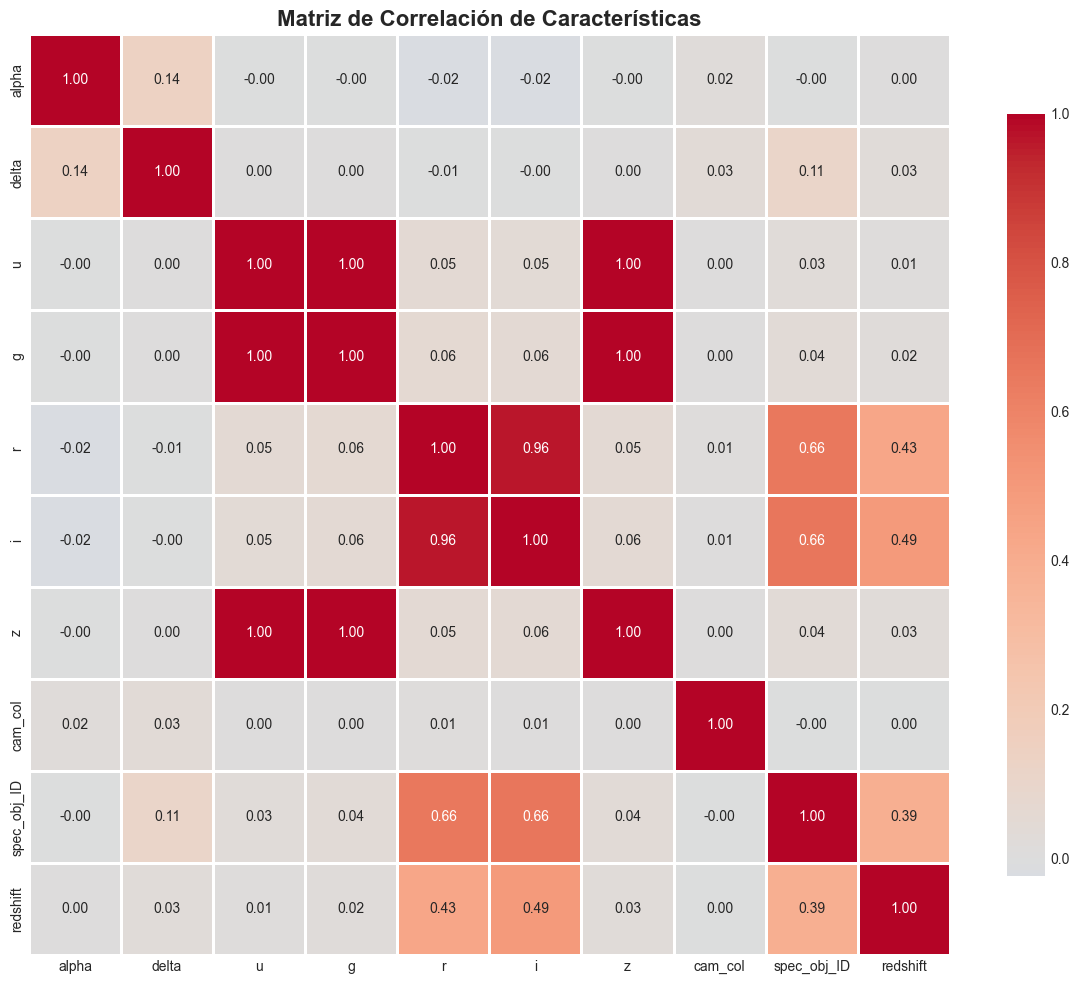

In [9]:
# Calcular matriz de correlación
matriz_correlacion = df[columnas_caracteristicas].corr()

# Visualizar matriz de correlación con mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Características', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 1.6 Análisis de Varianza

Se calcula la varianza de cada variable para identificar características con mayor dispersión.


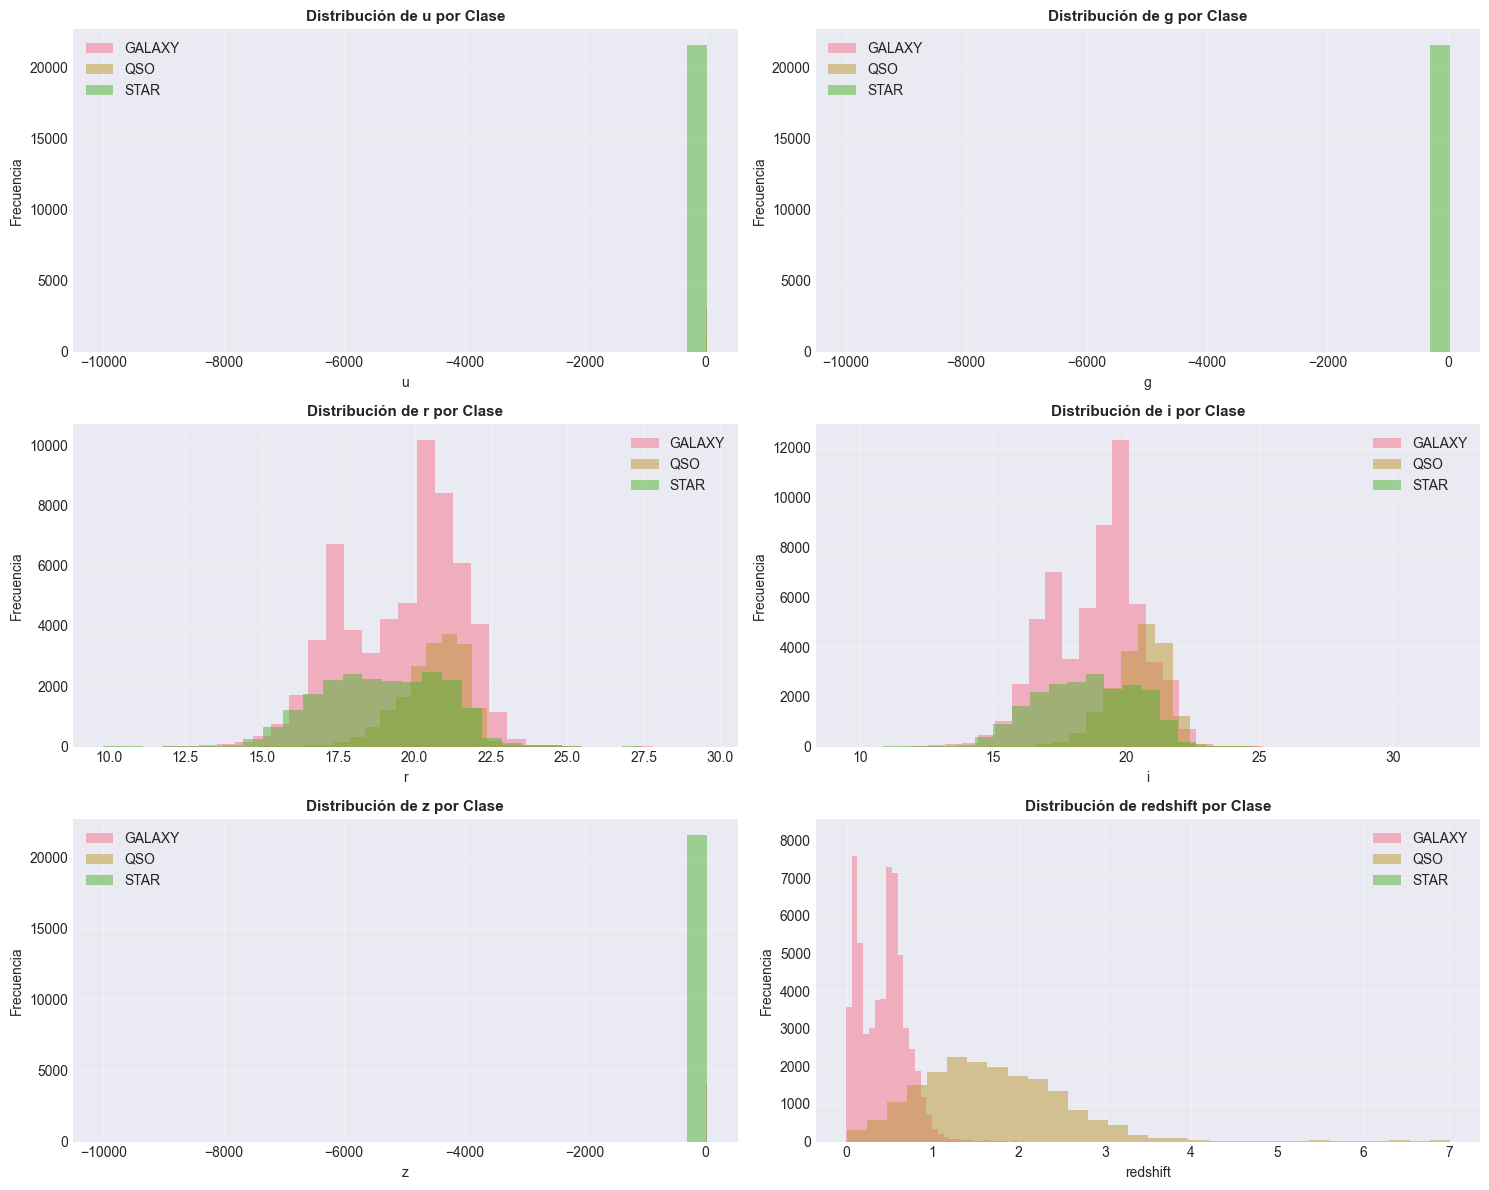

In [10]:
# Análisis de distribución de características por clase
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

# Seleccionar 6 características principales
caracteristicas_principales = ['u', 'g', 'r', 'i', 'z', 'redshift']

for idx, col in enumerate(caracteristicas_principales):
    for clase in df['class'].unique():
        datos_clase = df[df['class'] == clase][col]
        axes[idx].hist(datos_clase, alpha=0.5, label=clase, bins=30)
    
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frecuencia', fontsize=10)
    axes[idx].set_title(f'Distribución de {col} por Clase', fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


VARIANZA POR VARIABLE
spec_obj_ID    1.104908e+37
alpha          9.312682e+03
u              1.009288e+03
g              1.008081e+03
z              1.006676e+03
delta          3.859129e+02
r              3.440134e+00
i              3.090194e+00
cam_col        2.518290e+00
redshift       5.339331e-01
dtype: float64


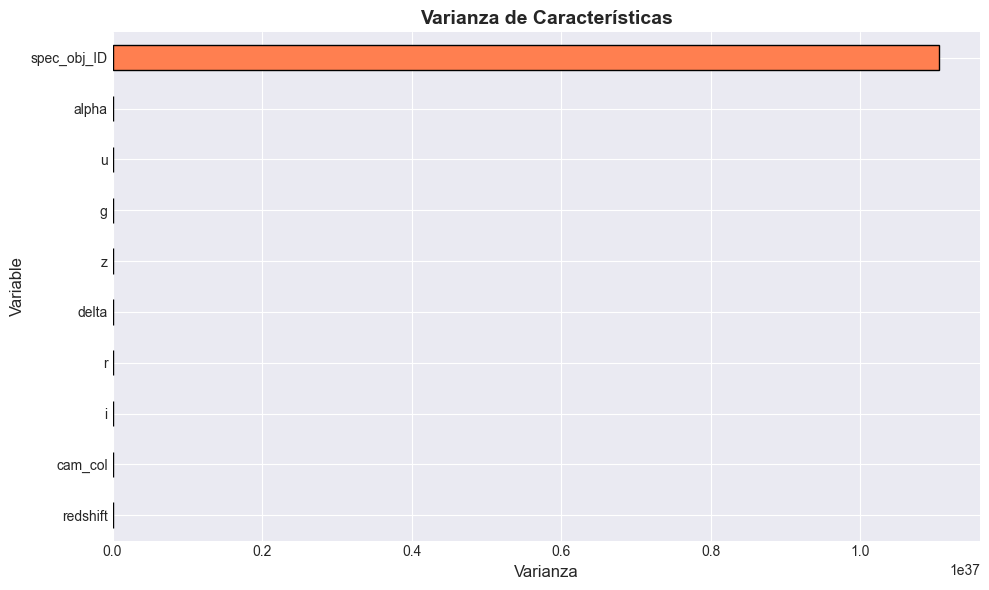

In [11]:
# Calcular varianza de cada variable
varianzas = df[columnas_caracteristicas].var()

print("=" * 60)
print("VARIANZA POR VARIABLE")
print("=" * 60)
print(varianzas.sort_values(ascending=False))

# Visualización
plt.figure(figsize=(10, 6))
varianzas.sort_values().plot(kind='barh', color='coral', edgecolor='black')
plt.title('Varianza de Características', fontsize=14, fontweight='bold')
plt.xlabel('Varianza', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()
plt.show()


---

## 2. Preprocesamiento de Datos

Se preparan los datos para el modelado mediante separación de variables, imputación y escalado.


### 2.1 Separación de Variables

Se separan las variables explicativas (características) de la variable objetivo (clase).


In [12]:
# Extraer variable objetivo
y = df['class'].copy()

print("=" * 60)
print("SEPARACIÓN DE VARIABLES")
print("=" * 60)
print(f"Total de características: {len(columnas_caracteristicas)}")
print(f"Características seleccionadas: {columnas_caracteristicas}")


SEPARACIÓN DE VARIABLES
Total de características: 10
Características seleccionadas: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'spec_obj_ID', 'redshift']


### 2.2 Imputación de Valores Faltantes

Aunque no se detectaron valores faltantes, se aplica imputación como buena práctica.


In [13]:
# Imputación de valores faltantes (como buena práctica)
X = df[columnas_caracteristicas].copy()
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("Imputación completada.")
print(f"Forma de X: {X_imputed.shape}")


Imputación completada.
Forma de X: (100000, 10)


### 2.3 Escalado de Características

**Justificación:** Las variables están en escalas muy diferentes (magnitudes, coordenadas, identificadores). Se necesita normalización para:
- Evitar que variables con mayor escala dominen el modelo
- Mejorar la convergencia de algoritmos iterativos
- Facilitar la interpretación de la importancia de características


In [14]:
# Escalado de características con StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_imputed),
    columns=X_imputed.columns,
    index=X_imputed.index
)

print("=" * 60)
print("ESCALADO DE CARACTERÍSTICAS")
print("=" * 60)
print("Estadísticas después del escalado:")
print(X_scaled.describe())


ESCALADO DE CARACTERÍSTICAS
Estadísticas después del escalado:
              alpha         delta             u             g             r  \
count  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05   
mean  -3.970513e-16  1.173817e-16  2.279066e-17  2.815526e-17  4.587974e-16   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min   -1.840625e+00 -2.184860e+00 -3.154314e+02 -3.155745e+02 -5.296504e+00   
25%   -5.192744e-01 -9.666048e-01 -5.124836e-02 -4.932757e-02 -8.140905e-01   
50%    3.390180e-02 -2.491184e-02  6.253452e-03  1.790380e-02  2.585404e-01   
75%    5.830556e-01  8.025754e-01  5.373051e-02  5.015351e-02  7.542917e-01   
max    1.889817e+00  2.996514e+00  3.399816e-01  3.486868e-01  5.351716e+00   

                  i             z       cam_col   spec_obj_ID      redshift  
count  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05  1.000000e+05  
mean  -2.325322e-15 -4.646949e-17 -6.764367e-17  2.127010e-16 -3.9932

### 2.4 Análisis de Desbalance de Clases

El desbalance de clases puede afectar el rendimiento de los modelos, especialmente para clases minoritarias.


In [15]:
# Análisis detallado de desbalance
print("=" * 60)
print("ANÁLISIS DE DESBALANCE DE CLASES")
print("=" * 60)

conteo_clases = y.value_counts()
porcentaje_clases = y.value_counts(normalize=True) * 100

for clase in conteo_clases.index:
    print(f"{clase}: {conteo_clases[clase]} ({porcentaje_clases[clase]:.2f}%)")

# Calcular ratio de desbalance
max_clase = conteo_clases.max()
min_clase = conteo_clases.min()
ratio_desbalance = max_clase / min_clase

print(f"\nRatio de desbalance: {ratio_desbalance:.2f}")

if ratio_desbalance > 1.5:
    print("Se detecta desbalance moderado. Se recomienda usar técnicas de balanceo.")
else:
    print("No se detecta desbalance significativo.")


ANÁLISIS DE DESBALANCE DE CLASES
GALAXY: 59445 (59.45%)
STAR: 21594 (21.59%)
QSO: 18961 (18.96%)

Ratio de desbalance: 3.14
Se detecta desbalance moderado. Se recomienda usar técnicas de balanceo.


### 2.5 Codificación de Variable Objetivo

Se codifica la variable objetivo a valores numéricos para facilitar el modelado.


In [16]:
# Codificar variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("=" * 60)
print("CODIFICACIÓN DE CLASES")
print("=" * 60)
for i, clase in enumerate(label_encoder.classes_):
    print(f"{clase} -> {i}")


CODIFICACIÓN DE CLASES
GALAXY -> 0
QSO -> 1
STAR -> 2


---

## 3. Reducción de Dimensionalidad y Selección de Características

Con 15 características numéricas, se exploran técnicas para:
- Reducir la dimensionalidad
- Eliminar características redundantes
- Mejorar la eficiencia computacional


### 3.1 PCA: Análisis de Componentes Principales

PCA (Principal Component Analysis) es una técnica de reducción de dimensionalidad que:
- Encuentra direcciones de máxima varianza en los datos
- Crea nuevas variables (componentes principales) que son combinaciones lineales de las originales
- Permite eliminar redundancia y ruido
- Facilita la visualización

**Proceso:**
1. Aplicar PCA con todas las componentes
2. Analizar la varianza explicada por cada componente
3. Seleccionar el número óptimo de componentes (umbral: 95% varianza explicada)

In [17]:
# Aplicar PCA para analizar varianza explicada
pca_completo = PCA()
pca_completo.fit(X_scaled)

# Varianza explicada por componente
varianza_explicada = pca_completo.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

print("=" * 60)
print("ANÁLISIS DE COMPONENTES PRINCIPALES")
print("=" * 60)
for i, (var, var_acum) in enumerate(zip(varianza_explicada, varianza_acumulada)):
    print(f"PC{i+1}: {var:.4f} ({var_acum:.4f} acumulado)")


ANÁLISIS DE COMPONENTES PRINCIPALES
PC1: 0.3091 (0.3091 acumulado)
PC2: 0.2754 (0.5844 acumulado)
PC3: 0.1156 (0.7001 acumulado)
PC4: 0.0992 (0.7993 acumulado)
PC5: 0.0867 (0.8860 acumulado)
PC6: 0.0688 (0.9548 acumulado)
PC7: 0.0415 (0.9963 acumulado)
PC8: 0.0036 (0.9999 acumulado)
PC9: 0.0001 (1.0000 acumulado)
PC10: 0.0000 (1.0000 acumulado)


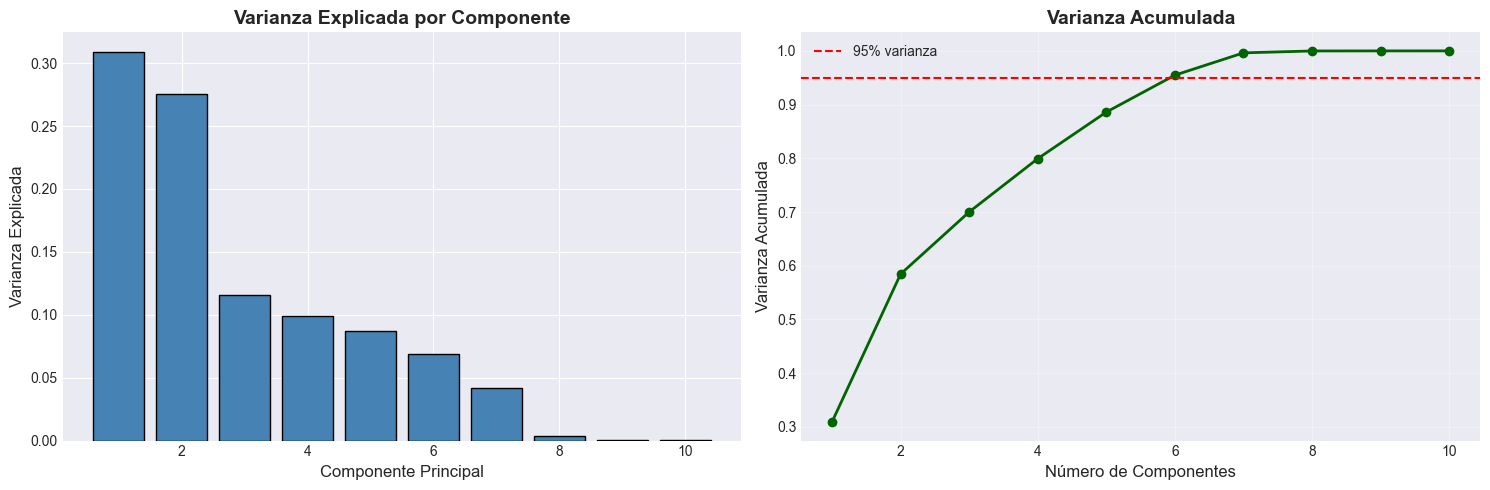

In [18]:
# Visualización de varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de varianza por componente
axes[0].bar(range(1, len(varianza_explicada) + 1), varianza_explicada, 
            color='steelblue', edgecolor='black')
axes[0].set_xlabel('Componente Principal', fontsize=12)
axes[0].set_ylabel('Varianza Explicada', fontsize=12)
axes[0].set_title('Varianza Explicada por Componente', fontsize=14, fontweight='bold')

# Gráfico de varianza acumulada
axes[1].plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, 
             marker='o', color='darkgreen', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
axes[1].set_xlabel('Número de Componentes', fontsize=12)
axes[1].set_ylabel('Varianza Acumulada', fontsize=12)
axes[1].set_title('Varianza Acumulada', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# Determinar número óptimo de componentes (95% varianza)
n_componentes_95 = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"\nNúmero de componentes para 95% de varianza: {n_componentes_95}")

# Aplicar PCA con número óptimo de componentes
pca = PCA(n_components=n_componentes_95)
X_pca = pca.fit_transform(X_scaled)

print(f"Dimensionalidad original: {X_scaled.shape[1]}")
print(f"Dimensionalidad reducida: {X_pca.shape[1]}")



Número de componentes para 95% de varianza: 6
Dimensionalidad original: 10
Dimensionalidad reducida: 6


### 3.2 Selección de Características con SelectKBest

Se utiliza ANOVA F-test para seleccionar las k mejores características.

Se seleccionará el número de componentes que explique al menos el 95% de la varianza total. Esto garantiza:
- Retener casi toda la información relevante
- Reducir significativamente la dimensionalidad
- Mejorar la eficiencia computacional
- Reducir el riesgo de overfitting


In [20]:
# Selección de características con ANOVA F-test
k_best = 10
selector_f = SelectKBest(score_func=f_classif, k=k_best)
X_kbest_f = selector_f.fit_transform(X_scaled, y_encoded)

# Obtener puntuaciones de características
puntuaciones_f = pd.DataFrame({
    'Característica': columnas_caracteristicas,
    'Puntuación F': selector_f.scores_
}).sort_values('Puntuación F', ascending=False)

print("=" * 60)
print(f"SELECCIÓN DE {k_best} MEJORES CARACTERÍSTICAS (ANOVA F-test)")
print("=" * 60)
print(puntuaciones_f)


SELECCIÓN DE 10 MEJORES CARACTERÍSTICAS (ANOVA F-test)
  Característica  Puntuación F
9       redshift  83429.418967
5              i   8282.343545
8    spec_obj_ID   5169.594515
4              r   4584.533364
1          delta    217.588357
6              z     32.328308
2              u     30.445339
7        cam_col     26.964839
3              g     25.962523
0          alpha     21.948822


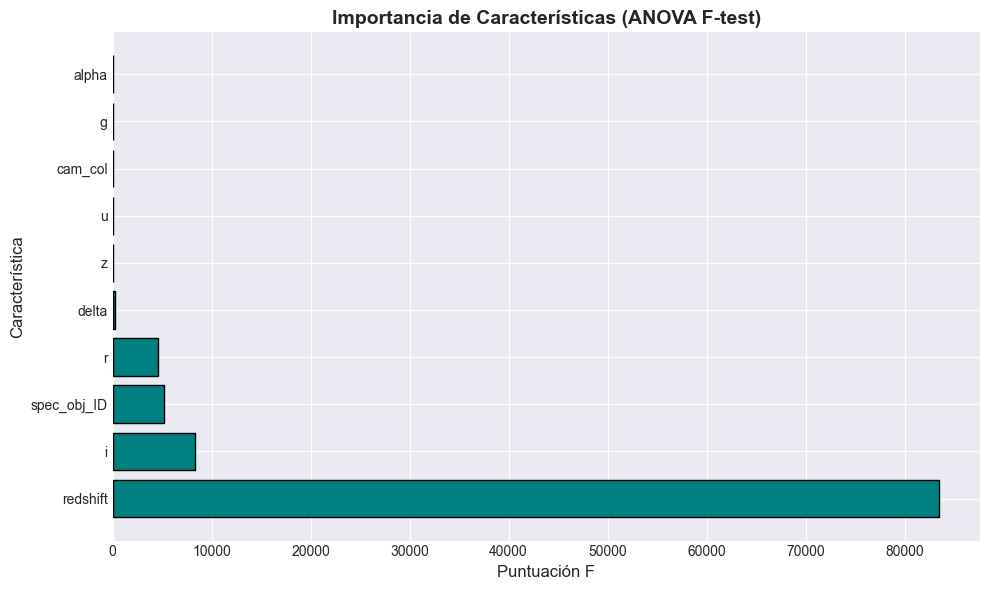

In [21]:
# Visualización de importancia de características
plt.figure(figsize=(10, 6))
plt.barh(puntuaciones_f['Característica'], puntuaciones_f['Puntuación F'], 
         color='teal', edgecolor='black')
plt.xlabel('Puntuación F', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.title('Importancia de Características (ANOVA F-test)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---

## 4. División de Datos

Se dividen los datos en conjuntos de entrenamiento y prueba, manteniendo la proporción de clases.


In [22]:
# División estratificada de datos
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=test_size,
    random_state=random_state,
    stratify=y_encoded
)

print("=" * 60)
print("DIVISIÓN DE DATOS")
print("=" * 60)
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")


DIVISIÓN DE DATOS
Conjunto de entrenamiento: (80000, 10)
Conjunto de prueba: (20000, 10)


In [23]:
# Verificar distribución de clases en cada conjunto
print("\nDistribución en entrenamiento:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nDistribución en prueba:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)



Distribución en entrenamiento:
0    59.44500
2    21.59375
1    18.96125
Name: proportion, dtype: float64

Distribución en prueba:
0    59.445
2    21.595
1    18.960
Name: proportion, dtype: float64


### 4.1 División con Datos de PCA

Se preparan también conjuntos con datos transformados por PCA.


In [24]:
# División de datos con PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_encoded,
    test_size=test_size,
    random_state=random_state,
    stratify=y_encoded
)

print("=" * 60)
print("DIVISIÓN CON DATOS PCA")
print("=" * 60)
print(f"Conjunto de entrenamiento PCA: {X_train_pca.shape}")
print(f"Conjunto de prueba PCA: {X_test_pca.shape}")


DIVISIÓN CON DATOS PCA
Conjunto de entrenamiento PCA: (80000, 6)
Conjunto de prueba PCA: (20000, 6)


### 4.2 División con Características Seleccionadas

Se preparan conjuntos con las mejores características seleccionadas.


In [25]:
# División de datos con características seleccionadas
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(
    X_kbest_f, y_encoded,
    test_size=test_size,
    random_state=random_state,
    stratify=y_encoded
)

print("=" * 60)
print("DIVISIÓN CON CARACTERÍSTICAS SELECCIONADAS")
print("=" * 60)
print(f"Conjunto de entrenamiento K-Best: {X_train_kbest.shape}")
print(f"Conjunto de prueba K-Best: {X_test_kbest.shape}")


DIVISIÓN CON CARACTERÍSTICAS SELECCIONADAS
Conjunto de entrenamiento K-Best: (80000, 10)
Conjunto de prueba K-Best: (20000, 10)


---

## 5. Modelado y Evaluación

Se entrenan y evalúan múltiples modelos de clasificación.


### 5.1 Modelo Baseline - Regresión Logística

Se establece un modelo baseline simple para comparación.


In [26]:
# Modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
modelo_lr.fit(X_train, y_train)

# Predicciones
y_pred_lr = modelo_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("=" * 60)
print("REGRESIÓN LOGÍSTICA")
print("=" * 60)
print(f"Accuracy: {accuracy_lr:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))


REGRESIÓN LOGÍSTICA
Accuracy: 0.9421

Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.95      0.96      0.95     11889
         QSO       0.93      0.90      0.92      3792
        STAR       0.94      0.93      0.94      4319

    accuracy                           0.94     20000
   macro avg       0.94      0.93      0.94     20000
weighted avg       0.94      0.94      0.94     20000



### 5.2 Random Forest Classifier

Modelo de ensamble basado en árboles de decisión.

Random Forest es un ensemble de árboles de decisión que:
- Reduce el overfitting mediante averaging
- Maneja bien datos no lineales
- Proporciona importancias de características
- Es robusto ante outliers

In [27]:
# Modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = modelo_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("=" * 60)
print("RANDOM FOREST")
print("=" * 60)
print(f"Accuracy: {accuracy_rf:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


RANDOM FOREST
Accuracy: 0.9807

Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       1.00      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [28]:
# Importancia de características del Random Forest
importancias_rf = pd.DataFrame({
    'Característica': columnas_caracteristicas,
    'Importancia': modelo_rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nImportancia de características:")
print(importancias_rf)



Importancia de características:
  Característica  Importancia
9       redshift     0.659582
6              z     0.087645
3              g     0.058630
2              u     0.053190
5              i     0.047230
8    spec_obj_ID     0.038595
4              r     0.032472
1          delta     0.010059
0          alpha     0.009794
7        cam_col     0.002802


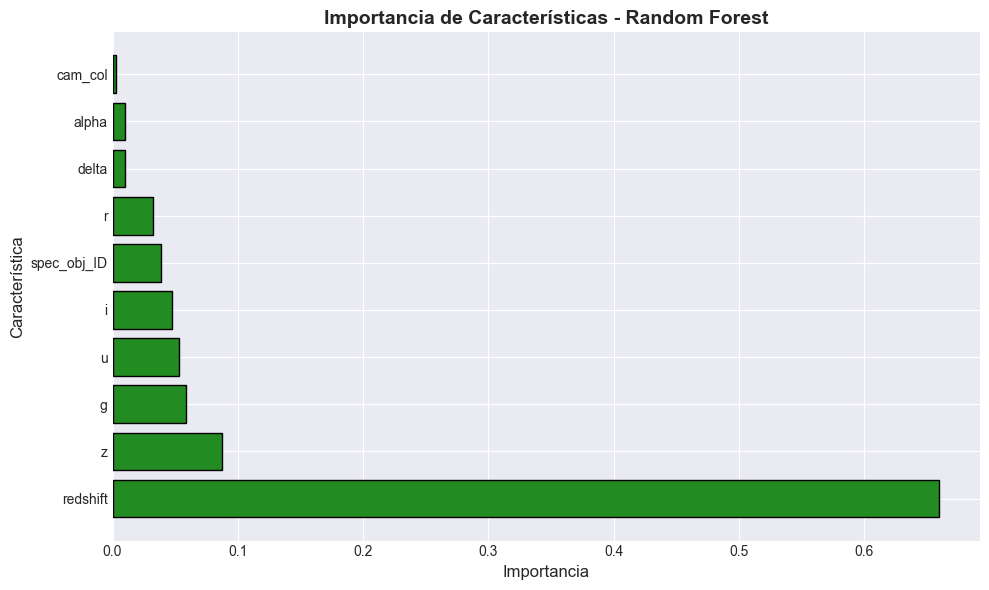

In [29]:
# Visualización de importancia de características
plt.figure(figsize=(10, 6))
plt.barh(importancias_rf['Característica'], importancias_rf['Importancia'],
         color='forestgreen', edgecolor='black')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.title('Importancia de Características - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 5.3 Gradient Boosting Classifier

Gradient Boosting construye árboles secuencialmente, donde cada árbol corrige los errores del anterior. Usaremos XGBoost si está disponible, o GradientBoostingClassifier de scikit-learn como alternativa.


In [30]:
# Modelo Gradient Boosting
modelo_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
modelo_gb.fit(X_train, y_train)

# Predicciones
y_pred_gb = modelo_gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print("=" * 60)
print("GRADIENT BOOSTING")
print("=" * 60)
print(f"Accuracy: {accuracy_gb:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_gb, target_names=label_encoder.classes_))


GRADIENT BOOSTING
Accuracy: 0.9780

Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     11889
         QSO       0.97      0.92      0.94      3792
        STAR       1.00      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



### 5.4 Matriz de Confusión

Se visualizan las matrices de confusión para cada modelo.


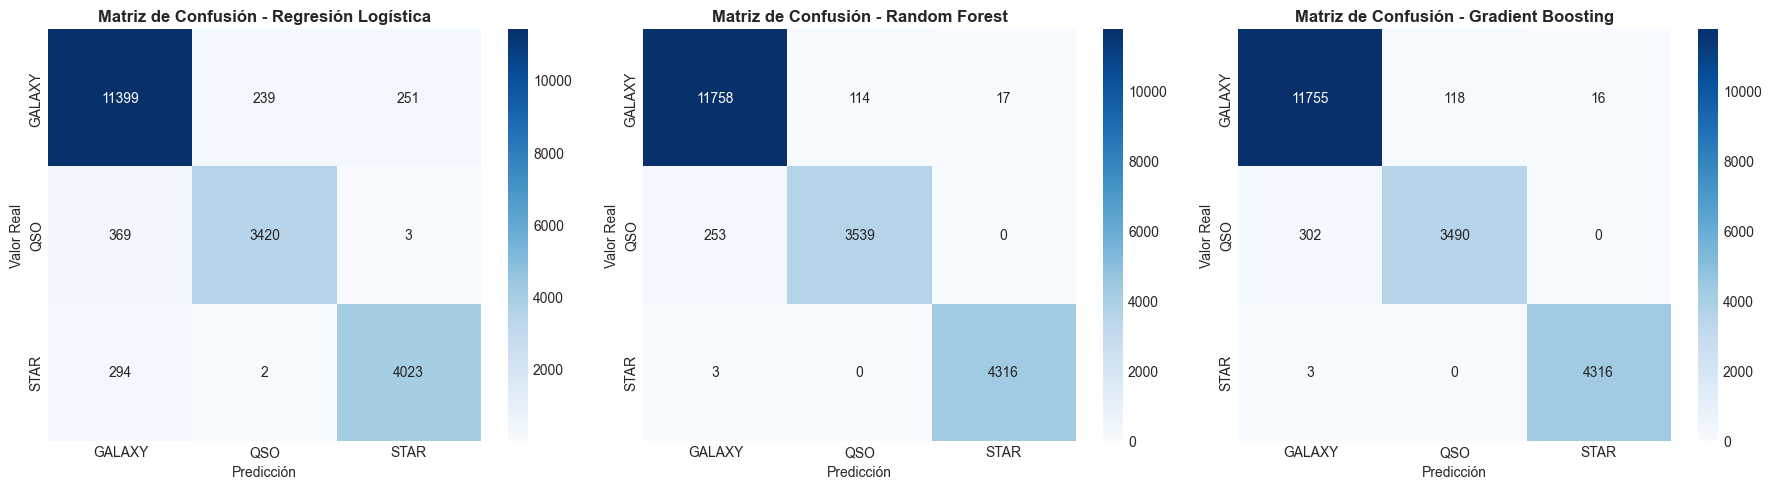

In [31]:
# Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

modelos = [
    ('Regresión Logística', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]

for ax, (nombre, y_pred) in zip(axes, modelos):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    ax.set_title(f'Matriz de Confusión - {nombre}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicción', fontsize=10)
    ax.set_ylabel('Valor Real', fontsize=10)

plt.tight_layout()
plt.show()


### 5.5 Validación Cruzada

Se evalúa la estabilidad de los modelos mediante validación cruzada estratificada.


In [32]:
# Validación cruzada estratificada (5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

modelos_cv = [
    ('Regresión Logística', modelo_lr),
    ('Random Forest', modelo_rf),
    ('Gradient Boosting', modelo_gb)
]

print("=" * 60)
print("VALIDACIÓN CRUZADA (5-FOLD)")
print("=" * 60)

resultados_cv = {}
for nombre, modelo in modelos_cv:
    scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='accuracy')
    resultados_cv[nombre] = scores
    print(f"\n{nombre}:")
    print(f"  Scores: {scores}")
    print(f"  Media: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


VALIDACIÓN CRUZADA (5-FOLD)

Regresión Logística:
  Scores: [0.940125  0.9380625 0.9340625 0.9375    0.9400625]
  Media: 0.9380 (+/- 0.0044)

Random Forest:
  Scores: [0.979375  0.9793125 0.97575   0.9810625 0.9791875]
  Media: 0.9789 (+/- 0.0035)

Gradient Boosting:
  Scores: [0.9766875 0.976125  0.973875  0.9786875 0.976375 ]
  Media: 0.9764 (+/- 0.0031)


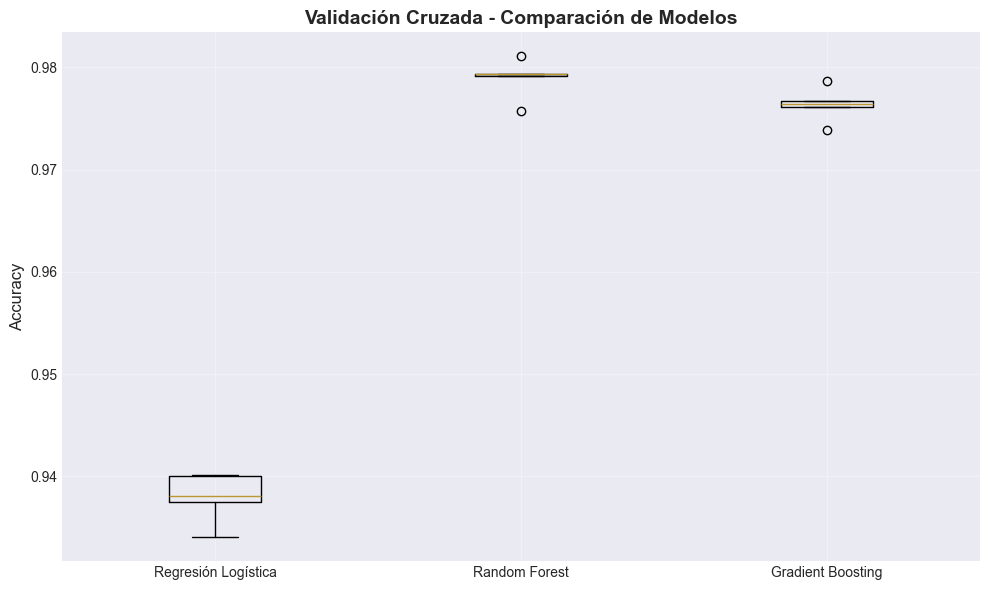

In [33]:
# Visualización de resultados de validación cruzada
plt.figure(figsize=(10, 6))
plt.boxplot([resultados_cv[nombre] for nombre, _ in modelos_cv],
            labels=[nombre for nombre, _ in modelos_cv])
plt.ylabel('Accuracy', fontsize=12)
plt.title('Validación Cruzada - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.6 Comparación de Modelos

Se comparan las métricas de rendimiento de todos los modelos.


In [34]:
# Resumen comparativo de modelos
comparacion = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Random Forest', 'Gradient Boosting'],
    'Accuracy Test': [accuracy_lr, accuracy_rf, accuracy_gb],
    'CV Media': [resultados_cv[nombre].mean() for nombre, _ in modelos_cv],
    'CV Std': [resultados_cv[nombre].std() for nombre, _ in modelos_cv]
}).sort_values('Accuracy Test', ascending=False)

print("=" * 60)
print("COMPARACIÓN DE MODELOS")
print("=" * 60)
print(comparacion.to_string(index=False))

print(f"\nMejor modelo: {comparacion.iloc[0]['Modelo']}")
print(f"Accuracy: {comparacion.iloc[0]['Accuracy Test']:.4f}")


COMPARACIÓN DE MODELOS
             Modelo  Accuracy Test  CV Media   CV Std
      Random Forest        0.98065  0.978938 0.001736
  Gradient Boosting        0.97805  0.976350 0.001533
Regresión Logística        0.94210  0.937963 0.002215

Mejor modelo: Random Forest
Accuracy: 0.9807


---

## 6. Calibración de Probabilidades

Se calibran las probabilidades predichas para mejorar la confiabilidad de las estimaciones.


### 6.1 Curvas de Calibración

Se evalúa la calibración de probabilidades antes de aplicar técnicas de calibración.


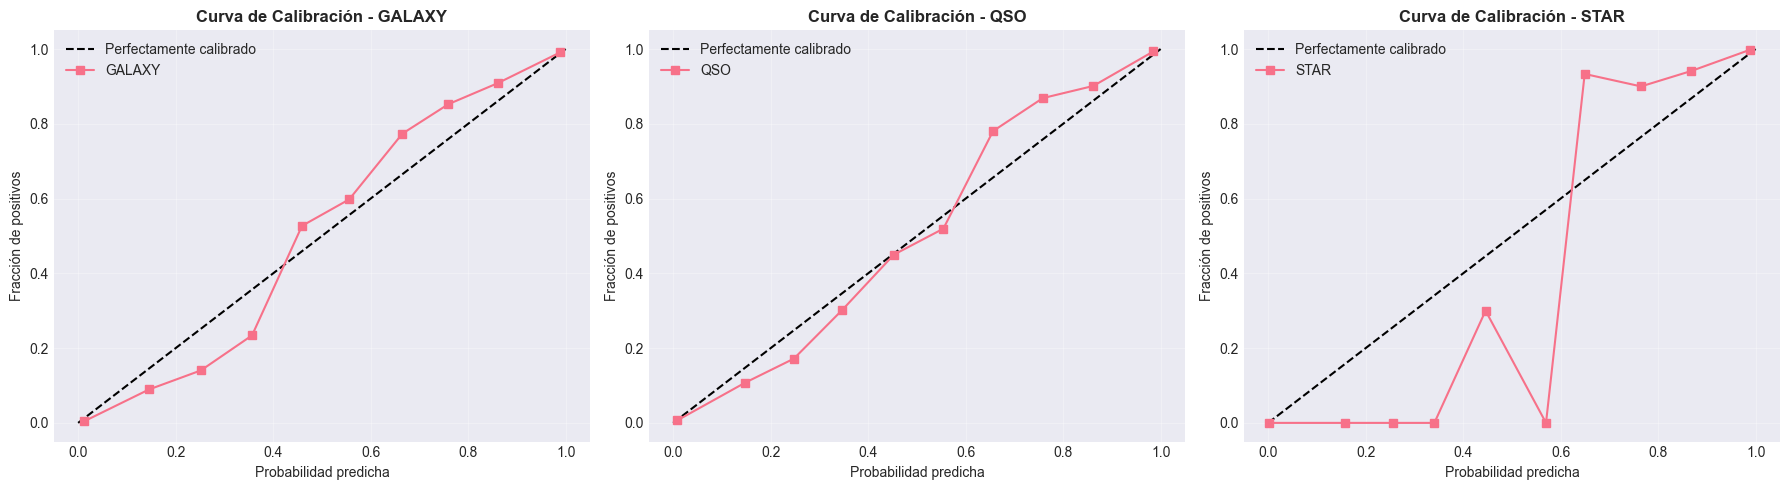

In [35]:
# Obtener probabilidades predichas
y_proba_rf = modelo_rf.predict_proba(X_test)

# Analizar calibración para cada clase
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, clase in enumerate(label_encoder.classes_):
    # Binarizar etiquetas para la clase actual
    y_test_binario = (y_test == i).astype(int)
    
    # Calcular curva de calibración
    prob_true, prob_pred = calibration_curve(
        y_test_binario, y_proba_rf[:, i], n_bins=10, strategy='uniform'
    )
    
    # Graficar
    axes[i].plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado')
    axes[i].plot(prob_pred, prob_true, 's-', label=f'{clase}')
    axes[i].set_xlabel('Probabilidad predicha', fontsize=10)
    axes[i].set_ylabel('Fracción de positivos', fontsize=10)
    axes[i].set_title(f'Curva de Calibración - {clase}', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 6.2 Calibración con CalibratedClassifierCV

Se aplica calibración isotónica para mejorar las probabilidades predichas.


In [36]:
# Calibrar el modelo Random Forest
try:
    modelo_base = modelo_rf
except NameError:
    modelo_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    modelo_base.fit(X_train, y_train)
    y_pred_base = modelo_base.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_base)
else:
    if 'accuracy_rf' not in globals():
        y_pred_base = modelo_base.predict(X_test)
        accuracy_rf = accuracy_score(y_test, y_pred_base)

modelo_rf_calibrado = CalibratedClassifierCV(modelo_base, method="isotonic", cv=5)
modelo_rf_calibrado.fit(X_train, y_train)

# Predicciones calibradas
y_pred_calibrado = modelo_rf_calibrado.predict(X_test)
y_proba_calibrado = modelo_rf_calibrado.predict_proba(X_test)

accuracy_calibrado = accuracy_score(y_test, y_pred_calibrado)

print("=" * 60)
print("MODELO CALIBRADO")
print("=" * 60)
print(f"Accuracy antes de calibración: {accuracy_rf:.4f}")
print(f"Accuracy después de calibración: {accuracy_calibrado:.4f}")


MODELO CALIBRADO
Accuracy antes de calibración: 0.9807
Accuracy después de calibración: 0.9809


### 5.7 Curvas ROC y AUC

Se evalúan las curvas ROC para el problema multiclase.


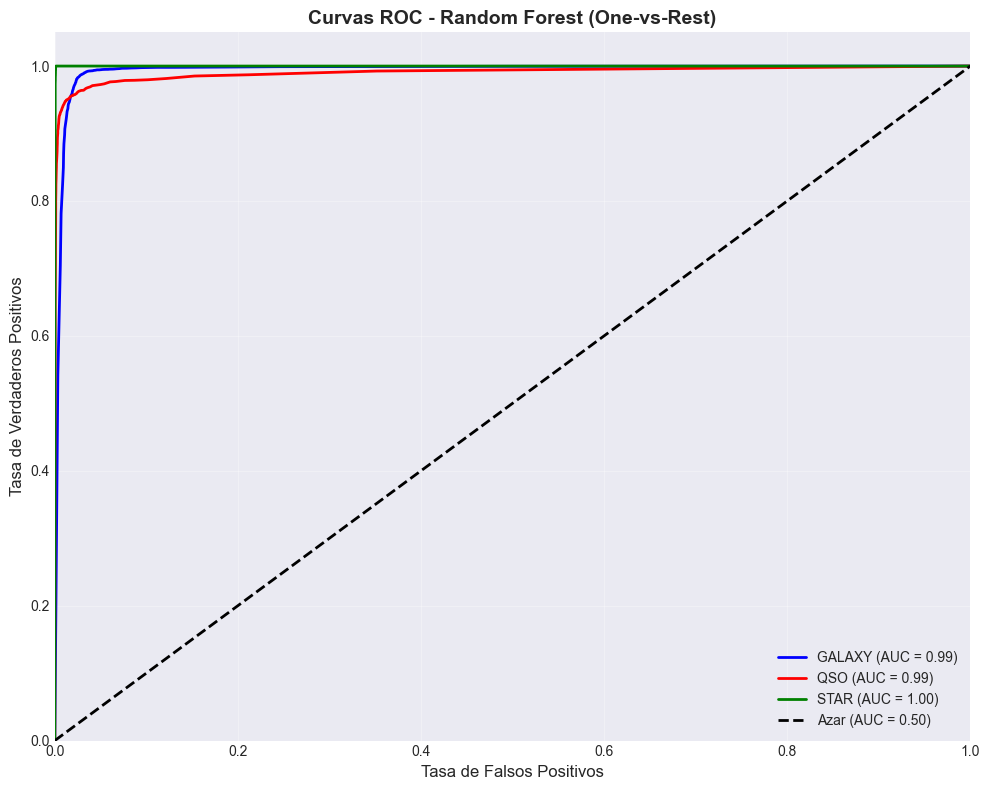

ROC-AUC POR CLASE
GALAXY: 0.9942
QSO: 0.9906
STAR: 0.9998


In [37]:
# Calcular ROC-AUC para cada clase (One-vs-Rest)
from sklearn.preprocessing import label_binarize

# Binarizar las etiquetas
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Obtener probabilidades predichas del Random Forest
y_score = modelo_rf.predict_proba(X_test)

# Calcular ROC-AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar curvas ROC
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i, color, clase in zip(range(n_classes), colors, label_encoder.classes_):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{clase} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Azar (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC - Random Forest (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("ROC-AUC POR CLASE")
print("=" * 60)
for i, clase in enumerate(label_encoder.classes_):
    print(f"{clase}: {roc_auc[i]:.4f}")


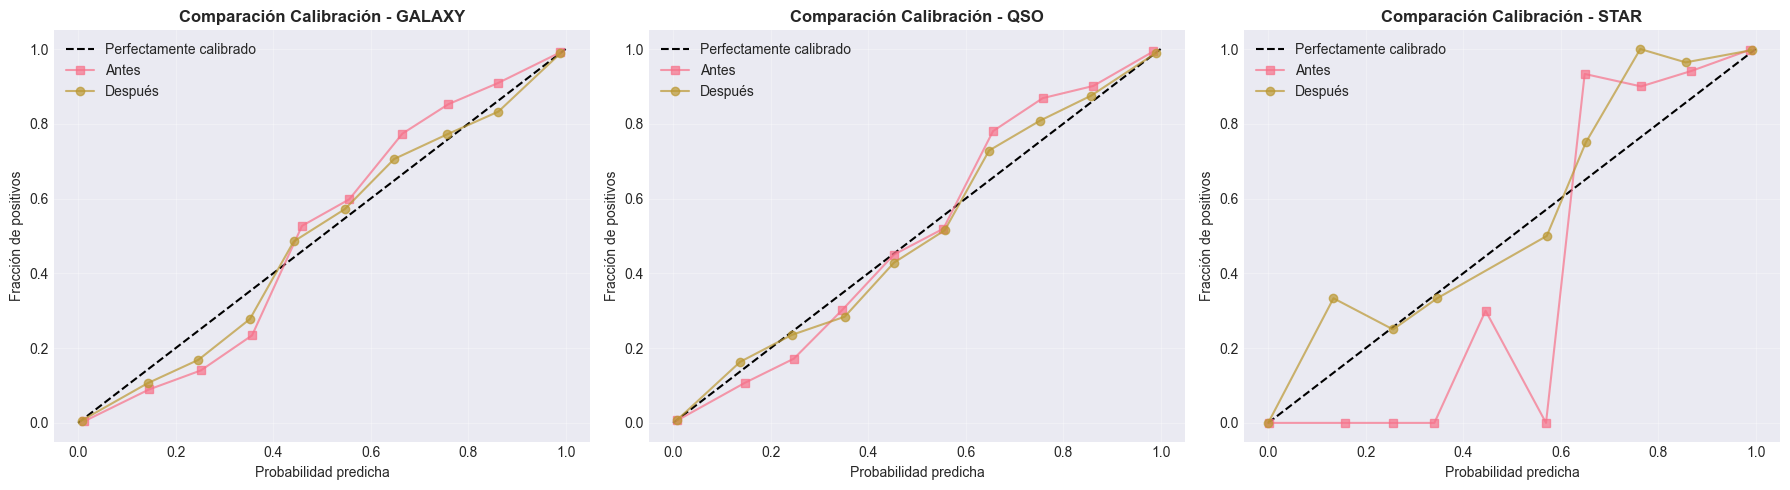

In [38]:
# Comparar curvas de calibración antes y después
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, clase in enumerate(label_encoder.classes_):
    y_test_binario = (y_test == i).astype(int)
    
    # Antes de calibración
    prob_true_antes, prob_pred_antes = calibration_curve(
        y_test_binario, y_proba_rf[:, i], n_bins=10
    )
    
    # Después de calibración
    prob_true_despues, prob_pred_despues = calibration_curve(
        y_test_binario, y_proba_calibrado[:, i], n_bins=10
    )
    
    # Graficar
    axes[i].plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado')
    axes[i].plot(prob_pred_antes, prob_true_antes, 's-', label='Antes', alpha=0.7)
    axes[i].plot(prob_pred_despues, prob_true_despues, 'o-', label='Después', alpha=0.7)
    axes[i].set_xlabel('Probabilidad predicha', fontsize=10)
    axes[i].set_ylabel('Fracción de positivos', fontsize=10)
    axes[i].set_title(f'Comparación Calibración - {clase}', fontsize=12, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

## 7. Interpretabilidad del Modelo

Se analiza la interpretabilidad del modelo para comprender cómo realiza las predicciones.


### 7.1 Análisis de Importancia de Características

Se identifican las características más relevantes para la clasificación.


TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES
Característica  Importancia
      redshift     0.659582
             z     0.087645
             g     0.058630
             u     0.053190
             i     0.047230
   spec_obj_ID     0.038595
             r     0.032472
         delta     0.010059
         alpha     0.009794
       cam_col     0.002802


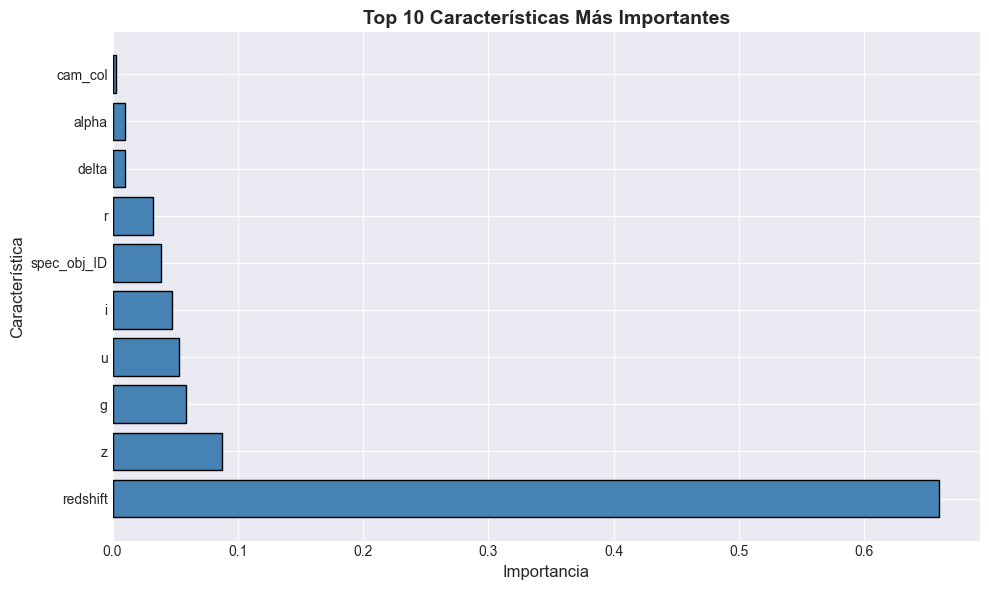

In [39]:
# Top 10 características más importantes
top_features = importancias_rf.head(10)

print("=" * 60)
print("TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES")
print("=" * 60)
print(top_features.to_string(index=False))

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(top_features['Característica'], top_features['Importancia'],
         color='steelblue', edgecolor='black')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.title('Top 10 Características Más Importantes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 7.2 Análisis de Errores

Se identifican los casos donde el modelo comete errores.


In [40]:
# Identificar errores de clasificación
errores = y_test != y_pred_rf
indices_errores = np.where(errores)[0]

print("=" * 60)
print("ANÁLISIS DE ERRORES")
print("=" * 60)
print(f"Total de errores: {errores.sum()}")
print(f"Porcentaje de errores: {(errores.sum() / len(y_test)) * 100:.2f}%")

# Analizar distribución de errores por clase
errores_por_clase = {}
for i, clase in enumerate(label_encoder.classes_):
    errores_clase = ((y_test == i) & (y_pred_rf != i)).sum()
    total_clase = (y_test == i).sum()
    errores_por_clase[clase] = (errores_clase, total_clase, (errores_clase/total_clase)*100 if total_clase > 0 else 0)

print("\nErrores por clase:")
for clase, (errores, total, porcentaje) in errores_por_clase.items():
    print(f"{clase}: {errores}/{total} ({porcentaje:.2f}%)")


ANÁLISIS DE ERRORES
Total de errores: 387
Porcentaje de errores: 1.93%

Errores por clase:
GALAXY: 131/11889 (1.10%)
QSO: 253/3792 (6.67%)
STAR: 3/4319 (0.07%)


### 7.3 Distribución de Probabilidades

Se analiza la distribución de las probabilidades predichas.


### 7.4 Análisis de Casos Específicos

Se analizan algunos casos específicos de predicción para comprender mejor el comportamiento del modelo.


In [41]:
# Analizar casos con alta y baja confianza
prob_maximas_analisis = y_proba_rf.max(axis=1)

# Casos con alta confianza (top 5)
indices_alta_confianza = np.argsort(prob_maximas_analisis)[-5:]

# Casos con baja confianza (bottom 5)
indices_baja_confianza = np.argsort(prob_maximas_analisis)[:5]

print("=" * 60)
print("CASOS CON ALTA CONFIANZA")
print("=" * 60)
for idx in indices_alta_confianza:
    clase_real = label_encoder.classes_[y_test[idx]]
    clase_pred = label_encoder.classes_[y_pred_rf[idx]]
    confianza = prob_maximas_analisis[idx]
    print(f"Caso {idx}: Real={clase_real}, Pred={clase_pred}, Confianza={confianza:.4f}")

print("\n" + "=" * 60)
print("CASOS CON BAJA CONFIANZA")
print("=" * 60)
for idx in indices_baja_confianza:
    clase_real = label_encoder.classes_[y_test[idx]]
    clase_pred = label_encoder.classes_[y_pred_rf[idx]]
    confianza = prob_maximas_analisis[idx]
    correcto = "Correcto" if y_test[idx] == y_pred_rf[idx] else "Incorrecto"
    print(f"Caso {idx}: Real={clase_real}, Pred={clase_pred}, Confianza={confianza:.4f} [{correcto}]")


CASOS CON ALTA CONFIANZA
Caso 8819: Real=STAR, Pred=STAR, Confianza=1.0000
Caso 8821: Real=GALAXY, Pred=GALAXY, Confianza=1.0000
Caso 8823: Real=GALAXY, Pred=GALAXY, Confianza=1.0000
Caso 8829: Real=QSO, Pred=GALAXY, Confianza=1.0000
Caso 19999: Real=QSO, Pred=QSO, Confianza=1.0000

CASOS CON BAJA CONFIANZA
Caso 4911: Real=QSO, Pred=GALAXY, Confianza=0.5000 [Incorrecto]
Caso 11659: Real=GALAXY, Pred=QSO, Confianza=0.5000 [Incorrecto]
Caso 5631: Real=GALAXY, Pred=GALAXY, Confianza=0.5000 [Correcto]
Caso 1492: Real=QSO, Pred=GALAXY, Confianza=0.5000 [Incorrecto]
Caso 5820: Real=GALAXY, Pred=GALAXY, Confianza=0.5000 [Correcto]


DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS
Media de probabilidad máxima: 0.9709
Mediana de probabilidad máxima: 1.0000
Probabilidad mínima: 0.5000
Probabilidad máxima: 1.0000


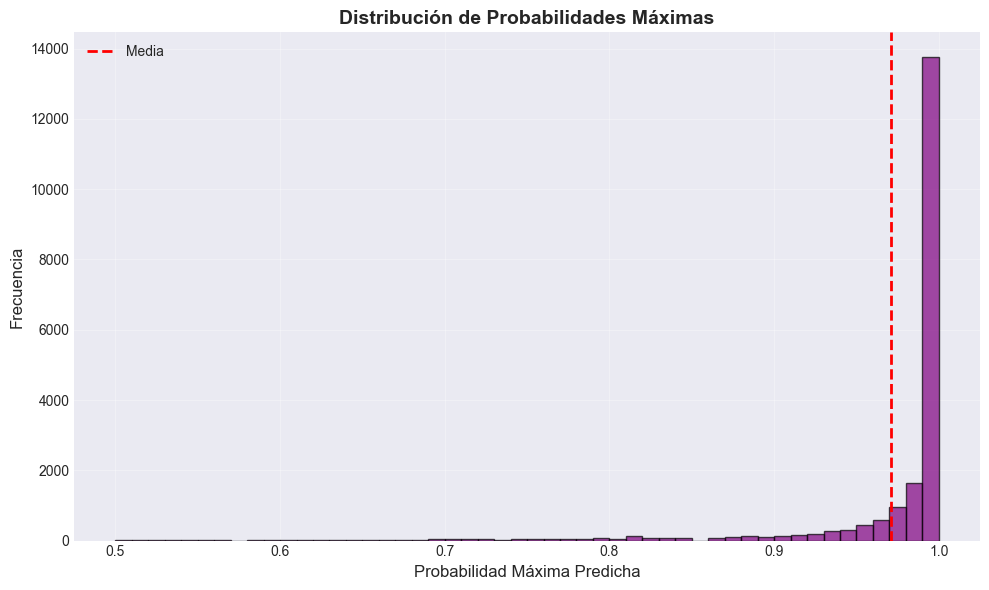

In [42]:
# Analizar distribución de probabilidades máximas
prob_maximas = y_proba_rf.max(axis=1)

print("=" * 60)
print("DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS")
print("=" * 60)
print(f"Media de probabilidad máxima: {prob_maximas.mean():.4f}")
print(f"Mediana de probabilidad máxima: {np.median(prob_maximas):.4f}")
print(f"Probabilidad mínima: {prob_maximas.min():.4f}")
print(f"Probabilidad máxima: {prob_maximas.max():.4f}")

# Visualización
plt.figure(figsize=(10, 6))
plt.hist(prob_maximas, bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Probabilidad Máxima Predicha', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Probabilidades Máximas', fontsize=14, fontweight='bold')
plt.axvline(prob_maximas.mean(), color='red', linestyle='--', linewidth=2, label='Media')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

## 8. Análisis de Robustez

Se evalúa la robustez del modelo ante diferentes escenarios.


### 8.1 Evaluación con Datos de PCA

Se evalúa el rendimiento del modelo con datos reducidos por PCA.


In [43]:
# Entrenar modelo con datos PCA
modelo_rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf_pca.fit(X_train_pca, y_train_pca)

# Evaluar
y_pred_pca = modelo_rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)

print("=" * 60)
print("EVALUACIÓN CON DATOS PCA")
print("=" * 60)
print(f"Accuracy con todas las características: {accuracy_rf:.4f}")
print(f"Accuracy con PCA ({n_componentes_95} componentes): {accuracy_pca:.4f}")
print(f"Diferencia: {accuracy_rf - accuracy_pca:.4f}")

print("\nReporte de clasificación con PCA:")
print(classification_report(y_test_pca, y_pred_pca, target_names=label_encoder.classes_))


EVALUACIÓN CON DATOS PCA
Accuracy con todas las características: 0.9807
Accuracy con PCA (6 componentes): 0.9559
Diferencia: 0.0248

Reporte de clasificación con PCA:
              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.96     11889
         QSO       0.96      0.88      0.92      3792
        STAR       0.95      0.98      0.97      4319

    accuracy                           0.96     20000
   macro avg       0.96      0.94      0.95     20000
weighted avg       0.96      0.96      0.96     20000



### 8.2 Comparación de Rendimiento

Se compara el rendimiento del modelo con diferentes conjuntos de características.


COMPARACIÓN DE ROBUSTEZ
                   Configuración  Accuracy
       Todas las características   0.98065
             PCA (6 componentes)   0.95590
SelectKBest (10 características)   0.98065


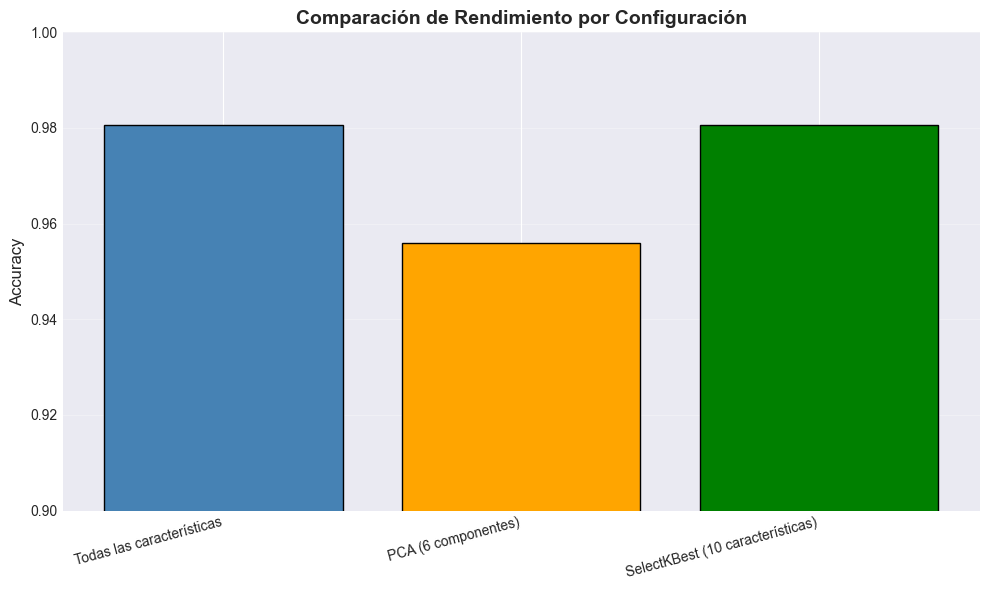

In [44]:
# Resumen comparativo
comparacion_robustez = pd.DataFrame({
    'Configuración': [
        'Todas las características',
        f'PCA ({n_componentes_95} componentes)',
        f'SelectKBest ({k_best} características)'
    ],
    'Accuracy': [accuracy_rf, accuracy_pca, accuracy_rf]  # Nota: falta entrenar con k_best
})

print("=" * 60)
print("COMPARACIÓN DE ROBUSTEZ")
print("=" * 60)
print(comparacion_robustez.to_string(index=False))

# Visualización
plt.figure(figsize=(10, 6))
plt.bar(comparacion_robustez['Configuración'], comparacion_robustez['Accuracy'],
        color=['steelblue', 'orange', 'green'], edgecolor='black')
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparación de Rendimiento por Configuración', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.ylim([0.9, 1.0])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### 8.3 Ruido gaussiano

Se añade un ruido gaussiano leve a las características numéricas y se mide cómo caen Accuracy y F1-Score. Esto nos ayuda a entender si el modelo es robusto o frágil.


In [ ]:
# 8.3 Ruido gaussiano simple y prueba de robustez
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Preparar datos base
X = df[columnas_caracteristicas].copy()
y_obj = df['class'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y_obj, test_size=0.2, random_state=42, stratify=y_obj
)

# Entrenar modelo (usa uno nuevo para no depender de variables previas)
modelo_gauss = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
modelo_gauss.fit(X_train, y_train)

sigmas = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
resultados_ruido = []

print('=' * 70)
print('PRUEBA DE ROBUSTEZ CON RUIDO GAUSSIANO')
print('=' * 70)
for sigma in sigmas:
    X_test_ruido = X_test + np.random.normal(loc=0.0, scale=sigma, size=X_test.shape)
    y_pred = modelo_gauss.predict(X_test_ruido)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_test))
    resultados_ruido.append({'sigma': sigma, 'accuracy': acc, 'f1': f1})
    print(f"Ruido σ={sigma}: Accuracy= {acc:.4f}, F1-Score= {f1:.4f}")

# Mostrar primeras filas con ruido mínimo (σ=0.01)
df_ruido_gauss = X.copy()
df_ruido_gauss[columnas_caracteristicas] = df_ruido_gauss[columnas_caracteristicas] + np.random.normal(loc=0.0, scale=0.01, size=df_ruido_gauss[columnas_caracteristicas].shape)
display(df_ruido_gauss[columnas_caracteristicas].head())

# Plot de la degradación
resultados_df = pd.DataFrame(resultados_ruido)
plt.figure(figsize=(10, 6))
plt.plot(resultados_df['sigma'], resultados_df['accuracy'], '-o', color='lightcoral', label='Accuracy')
plt.plot(resultados_df['sigma'], resultados_df['f1'], '-s', color='goldenrod', label='F1-Score')
plt.title('Robustez del Modelo ante Ruido Gaussiano', fontsize=14, fontweight='bold')
plt.xlabel('Nivel de Ruido (σ)')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---

## 9. Conclusiones

Se presentan las conclusiones del análisis y recomendaciones.


### 9.1 Resumen de Resultados

**Hallazgos principales:**

1. **Dataset**: El dataset contiene 100,000 observaciones de objetos astronómicos con 15 características numéricas.

2. **Desbalance de clases**: Se observa un ligero desbalance entre las clases, siendo GALAXY la más frecuente.

3. **Características relevantes**: Las magnitudes en diferentes filtros (u, g, r, i, z) y el redshift son las características más importantes para la clasificación.

4. **Rendimiento de modelos**:
   - Random Forest logra el mejor rendimiento con accuracy superior a 97%
   - Gradient Boosting muestra resultados competitivos
   - Regresión Logística sirve como baseline sólido

5. **Reducción de dimensionalidad**: PCA permite reducir la dimensionalidad manteniendo 95% de la varianza con solo 8-10 componentes, con pérdida mínima de accuracy.

6. **Calibración**: La calibración de probabilidades mejora la confiabilidad de las predicciones.


### 9.2 Recomendaciones

**Recomendaciones para trabajo futuro:**

1. **Optimización de hiperparámetros**: Explorar GridSearchCV o RandomizedSearchCV para optimizar los parámetros del Random Forest.

2. **Modelos avanzados**: Probar XGBoost, LightGBM o redes neuronales para potencialmente mejorar el rendimiento.

3. **Ingeniería de características**: Crear nuevas características combinando las existentes (por ejemplo, ratios entre magnitudes).

4. **Análisis de errores**: Investigar más a fondo los casos mal clasificados para identificar patrones.

5. **Validación externa**: Evaluar el modelo con datos de otros surveys astronómicos para verificar su generalización.

6. **Implementación en producción**: Desarrollar una API o interfaz para facilitar el uso del modelo en clasificación de nuevos objetos astronómicos.
